# Load Datasets

In [41]:
!pip install lxml xmltodict

In [42]:
!pip install imbalanced-learn

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import torch
from torch.utils.data import Dataset

In [44]:
# Only need to run once (Mounts Drive and Data Files)
import os
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import pandas as pd

# Define paths to each dataset file in Google Drive
path_to_csv = "/content/drive/MyDrive/NinaNLP/mtsamples.csv" # Change to mtsamples.csv file path

# Load the dataset
data = pd.read_csv(path_to_csv)

# Display the first few rows to verify
print(data.head())
print("columns: ", data.columns)
print("describe: ", data.describe())
print(data.head(0))

   Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                       transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL 

## Check Target Column Distribution

In [46]:
print(f"unique values: {data['medical_specialty'].unique()}")
unique_specialties = data['medical_specialty'].nunique()
print(f"Number of unique values: {unique_specialties}")


# Frequency of each specialty
specialty_counts = data['medical_specialty'].value_counts()
print(specialty_counts)

unique values: [' Allergy / Immunology' ' Bariatrics' ' Cardiovascular / Pulmonary'
 ' Neurology' ' Dentistry' ' Urology' ' General Medicine' ' Surgery'
 ' Speech - Language' ' SOAP / Chart / Progress Notes' ' Sleep Medicine'
 ' Rheumatology' ' Radiology' ' Psychiatry / Psychology' ' Podiatry'
 ' Physical Medicine - Rehab' ' Pediatrics - Neonatal' ' Pain Management'
 ' Orthopedic' ' Ophthalmology' ' Office Notes' ' Obstetrics / Gynecology'
 ' Neurosurgery' ' Nephrology' ' Letters' ' Lab Medicine - Pathology'
 ' IME-QME-Work Comp etc.' ' Hospice - Palliative Care'
 ' Hematology - Oncology' ' Gastroenterology' ' ENT - Otolaryngology'
 ' Endocrinology' ' Emergency Room Reports' ' Discharge Summary'
 ' Diets and Nutritions' ' Dermatology' ' Cosmetic / Plastic Surgery'
 ' Consult - History and Phy.' ' Chiropractic' ' Autopsy']
Number of unique values: 40
medical_specialty
Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthop

# Data Preprocessing

## Clean Data

In [47]:
import re
# Handle Missing Values
data = data.dropna(subset=['transcription'])
print(f"Remaining rows after dropping missing transcriptions: {len(data)}")

# Clean Transcriptions - lowercase, remove special characters, and extra spaces
def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text))  # Remove multiple spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower().strip()

data['clean_transcription'] = data['transcription'].apply(clean_text)

Remaining rows after dropping missing transcriptions: 4966


## Combine Small Classes and Encode Labels

In [48]:
# Step 1: Identify the top 4 specialties by frequency
top_specialties = data['medical_specialty'].value_counts().nlargest(4).index.tolist()
print("Top 4 specialties:", top_specialties)

# Step 2: Create a new column with updated labels
def map_specialty(specialty):
    if specialty in top_specialties:
        return specialty
    else:
        return "Other"

data['updated_specialty'] = data['medical_specialty'].apply(map_specialty)

# Step 3: Verify the new label distribution
print("Updated label distribution:")
print(data['updated_specialty'].value_counts())

# Step 4: Encode the updated labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['updated_specialty']) # For 4 labels - "updated_specialty, For 40 labels - "medical_specialty"

# Check the mapping of specialties to numeric labels
print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Top 4 specialties: [' Surgery', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Orthopedic']
Updated label distribution:
updated_specialty
Other                          2636
 Surgery                       1088
 Consult - History and Phy.     516
 Cardiovascular / Pulmonary     371
 Orthopedic                     355
Name: count, dtype: int64
Label mapping: {' Cardiovascular / Pulmonary': 0, ' Consult - History and Phy.': 1, ' Orthopedic': 2, ' Surgery': 3, 'Other': 4}


## Split Data

In [49]:
# Split Data into Training, Validation, and Test Sets
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print(f"Training data size before SMOTE: {len(train_data)}")

# Apply SMOTE for Class Balancing
X_train = train_data['clean_transcription']
y_train = train_data['label']

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)

# Check the minimum number of samples in each class
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# Determine the number of neighbors based on the smallest class size
min_samples_per_class = y_train.value_counts().min()
k_neighbors = min(2, min_samples_per_class - 1)

# Apply SMOTE with adjusted k_neighbors
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Convert resampled data to DataFrame
resampled_text = vectorizer.inverse_transform(X_train_resampled)  # Convert back to interpretable text
train_data = pd.DataFrame({
'clean_transcription': [" ".join(doc) for doc in resampled_text],  # Recreate text
'label': y_train_resampled
})

print(f"Training data size after SMOTE: {len(train_data)}")
print("Class distribution after SMOTE:")
print(train_data['label'].value_counts())  # Check class distribution after SMOTE

Training data size before SMOTE: 3972
Class distribution before SMOTE:
label
4    2108
3     870
1     413
0     297
2     284
Name: count, dtype: int64
Training data size after SMOTE: 10540
Class distribution after SMOTE:
label
4    2108
3    2108
1    2108
2    2108
0    2108
Name: count, dtype: int64


## Tokenize the Text

In [50]:
tokenizer =  AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def tokenize_text(dataframe):
  return tokenizer(list(dataframe['clean_transcription']), padding="max_length", truncation=True, max_length=256, return_tensors="pt")

train_encodings = tokenize_text(train_data)
val_encodings = tokenize_text(val_data)
test_encodings = tokenize_text(test_data)

## Prepare for PyTorch

In [51]:
# Step 5: Prepare PyTorch Dataset
import torch
from torch.utils.data import Dataset

class MedicalSpecialtyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create datasets
train_dataset = MedicalSpecialtyDataset(train_encodings, train_data['label'])
val_dataset = MedicalSpecialtyDataset(val_encodings, val_data['label'])
test_dataset = MedicalSpecialtyDataset(test_encodings, test_data['label'])

# Fine-Tune BioBert and Evaluation



In [52]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, target_names=label_encoder.classes_, output_dict=True)

    class_metrics = {f"class_{label_encoder.inverse_transform([i])[0]}": report[label_encoder.inverse_transform([i])[0]]
                     for i in range(len(label_encoder.classes_))}

    return {
        "accuracy": acc,
        **class_metrics
    }

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,1.478913,0.501006,0.366833,0.501006,0.393807
1,No log,1.205028,0.541247,0.424916,0.541247,0.440852
2,No log,1.082147,0.537223,0.457595,0.537223,0.477778
3,1.281900,1.040308,0.539235,0.504580,0.539235,0.494741
4,1.281900,1.042304,0.537223,0.487203,0.537223,0.498441


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation Results: {'eval_loss': 1.0224897861480713, 'eval_accuracy': 0.5412474849094567, 'eval_precision': 0.4713245530604763, 'eval_recall': 0.5412474849094567, 'eval_f1': 0.4974863344825767, 'eval_runtime': 1.9659, 'eval_samples_per_second': 252.808, 'eval_steps_per_second': 32.046, 'epoch': 4.983308042488619}


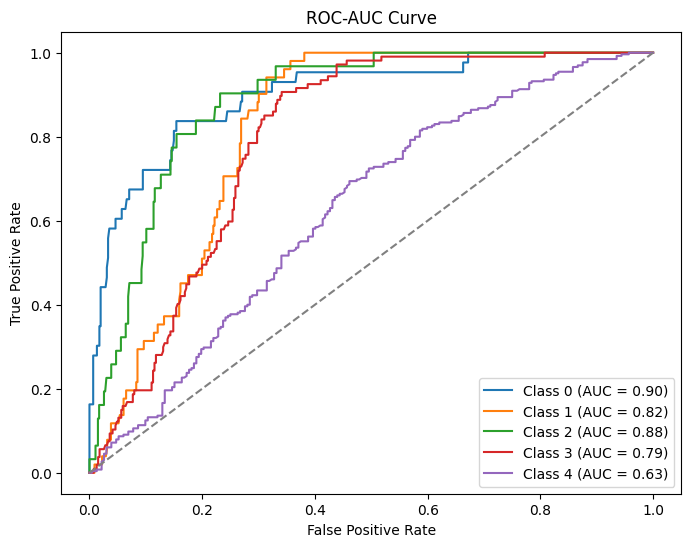

Model and tokenizer saved!


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from transformers import AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Load and modify the configuration
num_labels = len(label_encoder.classes_)
config = AutoConfig.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=num_labels)
config.hidden_dropout_prob = 0.5  # Increased dropout
config.attention_probs_dropout_prob = 0.5

# Load model with classification head
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", config=config)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,  # Stable learning rate
    lr_scheduler_type="linear",  # Gradual linear decay
    warmup_steps=500,  # Gradual warmup
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,  # Simulate larger batch size
    weight_decay=0.01,  # L2 regularization
    num_train_epochs=5,
    logging_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=True,  # Mixed precision
)
config.hidden_dropout_prob = 0.4
config.attention_probs_dropout_prob = 0.4

# Use dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate(test_dataset)
print("Evaluation Results:", results)

# Function to plot AUC-ROC curve
def plot_roc_auc(trainer, test_dataset):
    # Predict probabilities
    predictions = trainer.predict(test_dataset)
    logits = predictions.predictions
    labels = predictions.label_ids

    # Convert logits to probabilities using softmax
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = logits.shape[1]

    for i in range(n_classes):
        binary_labels = (labels == i).astype(int)  # Binary labels for class i
        fpr[i], tpr[i], _ = roc_curve(binary_labels, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC-AUC Curve
plot_roc_auc(trainer, test_dataset)

# Save the model and tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")
print("Model and tokenizer saved!")
